In [1]:
# 基于cnn卷积神经网络的水果图片分类项目
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
# 批大小
batch_size=32
# 是否使用cuda加速?,可选为cuda或者cpu
device="cuda"
# 学习率:学习率越大，参数更新的步长越大，但可能会导致训练不稳定；学习率越小，训练过程更稳定，但收敛速度可能会变慢。默认0.01
lr=0.001
# 定义训练周期:每个 Epoch 都会遍历一次完整的训练数据集。
Epoch=20

In [2]:
# 加载数据集
# 数据预处理

# 加载数据集
train_dataset = datasets.ImageFolder(
    root='fruits/Training',
    transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # 随机裁剪
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(degrees=10),  # 随机旋转（±10度）
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
)
test_dataset = datasets.ImageFolder(
    root='fruits/Test',
    transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
# 定义cnn卷积神经网络模型
# CNN模型(优化)
class FruitCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # 第一层卷积（添加BatchNorm）
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 第二层卷积（添加BatchNorm）
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # 第三层卷积（添加BatchNorm和额外Dropout）
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2)  # 新增卷积层后的Dropout
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 1024),  # 扩大中间层维度
            nn.ReLU(),
            nn.Dropout(0.6),  # 增强Dropout比例
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        # 前向传播
        x = self.features(x)  # 特征提取
        x = x.view(x.size(0), -1)  # 将特征图展平为一维向量
        return self.classifier(x)  # 分类


In [4]:
# 训练配置
if device == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")    
print(f"Using device: {device}")

# 创建一个 FruitCNN 模型实例，并将其移动到指定的设备（GPU 或 CPU）
model = FruitCNN(num_classes=len(train_dataset.classes)).to(device)
# 定义损失函数，用于衡量模型预测值与真实标签之间的差异。
criterion = nn.CrossEntropyLoss()
# 定义优化器，用于更新模型的参数以最小化损失函数。
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)  # 使用AdamW并增大权重衰减
# 定义学习率调度器，用于在训练过程中动态调整学习率。
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3,  # 3个epoch验证损失不降则降低学习率
    verbose=True
)

Using device: cuda


c:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# # 定义变量来跟踪最优性能
# best_acc = 0.0       # 最优验证准确率
# best_val_loss = float('inf')  # 最优验证损失
# patience_counter = 0  # 早停计数器
# patience = 7          # 早停耐心值（连续7个epoch无改进则停止）

# # 训练循环
# for epoch in range(Epoch):
#     model.train()     # 设置模型为训练模式
#     running_loss = 0.0
    
#     # 添加梯度裁剪（防止梯度爆炸）
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
        
#         # 前向传播
#         outputs = model(images)
        
#         # 使用标签平滑的交叉熵损失（smoothing=0.1）
#         loss = criterion(outputs, labels)
        
#         # 反向传播
#         loss.backward()
        
#         # 参数更新
#         optimizer.step()
        
#         running_loss += loss.item()

#     # 验证阶段
#     model.eval()
#     correct = 0
#     total = 0
#     val_loss = 0.0
    
#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
            
#             # 计算验证损失（不使用标签平滑）
#             loss = nn.CrossEntropyLoss()(outputs, labels)
#             val_loss += loss.item()
            
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     # 计算指标
#     avg_train_loss = running_loss / len(train_loader)
#     avg_val_loss = val_loss / len(test_loader)
#     avg_val_acc = 100 * correct / total
    
#     # 动态调整学习率（基于验证损失）
#     scheduler.step(avg_val_loss)  # 注意这里传入验证损失
    
#     # 打印监控信息
#     print(f"Epoch {epoch+1:02d} | "
#           f"Train Loss: {avg_train_loss:.4f} | "
#           f"Val Loss: {avg_val_loss:.4f} | "
#           f"Val Acc: {avg_val_acc:.2f}% | "
#           f"LR: {optimizer.param_groups[0]['lr']:.2e}")

#     # 早停机制和模型保存
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_acc = avg_val_acc
#         patience_counter = 0
        
#         # 保存最佳模型（同时记录loss和acc）
#         torch.save({
#             'epoch': epoch+1,
#             'state_dict': model.state_dict(),
#             'val_loss': avg_val_loss,
#             'val_acc': avg_val_acc
#         }, f"new_model/best_model_Loss_{avg_val_loss:.4f}_Acc_{avg_val_acc:.2f}%.pth")
#         print(f"▲ Saved new best model (Loss:{avg_val_loss:.4f}, Acc:{avg_val_acc:.2f}%)")
#     else:
#         patience_counter += 1
#         print(f"▼ No improvement ({patience_counter}/{patience})")
        
#         # 早停判断
#         if patience_counter >= patience:
#             print(f"⏹ Early stopping triggered at epoch {epoch+1}")
#             break


C:\Users\Spark\AppData\Local\Temp\ipykernel_14384\4282920656.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"new_model/best_model_Loss

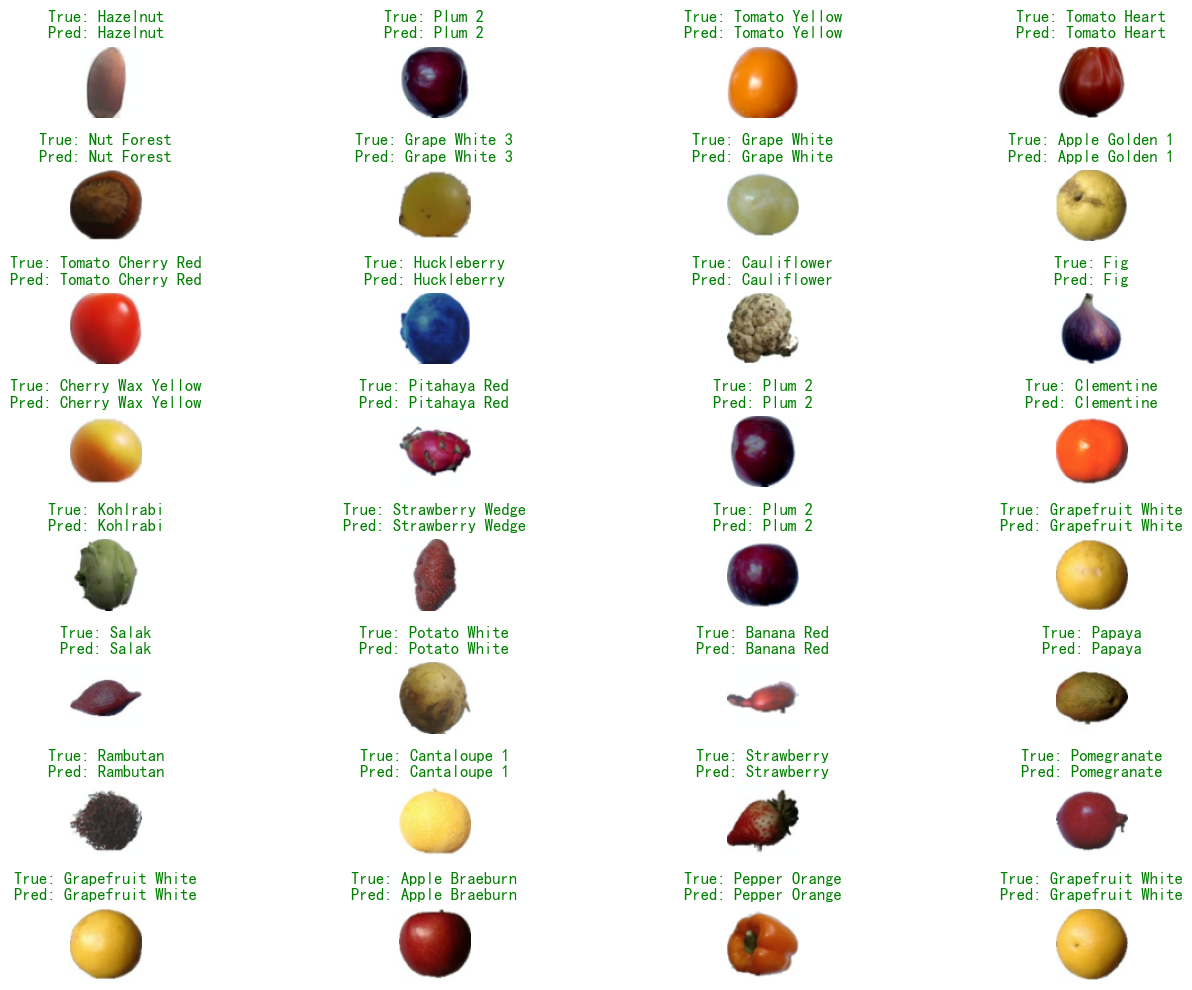

In [ ]:
# 可视化预测结果
# 加载标准模型
model = FruitCNN(num_classes=len(test_dataset.classes)).to(device)
# 加载模型参数(保存了训练参数和优化器状态)
model.load_state_dict(torch.load("new_model/best_model_Loss_0.0452_Acc_99.09%.pth", map_location=device)["state_dict"]) 
# 预测模式
model.eval()
# 预测和可视化函数
def visualize_predictions(test_loader, model, device, num_samples=32):
    # 获取一个批次的数据
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    # 进行预测
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # 转换图像为可显示格式
    images = images.cpu().numpy()
    images = images.transpose(0, 2, 3, 1)  # 从 (B, C, H, W) 转为 (B, H, W, C)
    
    # 反归一化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean  # 反归一化
    images = np.clip(images, 0, 1)  # 限制像素值在0-1之间
    
    # 创建可视化
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(images))):
        ax = plt.subplot(8, 4, i+1)
        plt.imshow(images[i])
        true_label = test_dataset.classes[labels[i].item()]
        pred_label = test_dataset.classes[preds[i].item()]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 5. 执行可视化
visualize_predictions(test_loader, model, device)